# Read in LES Data and Experiment with comparing to Model output

In [6]:
# activate 
using Pkg
Pkg.activate(".")
using YAML 
import ClimaAtmos as CA
using Revise
using Glob

  Activating project at `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/resolution_exp`


In [197]:
includet("get_les_metadata.jl")
includet("helper_funcs.jl")
includet("observation_map.jl")

In [19]:
# load in the 3 test sites
# les_17 = get_stats_path(get_cfsite_les_dir(17))
# les_23 = get_stats_path(get_cfsite_les_dir(23))
# les_30 = get_stats_path(get_cfsite_les_dir(30))
les_paths = glob("../../../../../../../Downloads/cfsite_data/*.nc") #"/Users/julianschmitt/Downloads/cfsite_data/*.nc"

3-element Vector{String}:
 "../../../../../../../Downloads/" ⋯ 26 bytes ⋯ "_HadGEM2-A_amip_2004-2008.07.nc"
 "../../../../../../../Downloads/" ⋯ 26 bytes ⋯ "_HadGEM2-A_amip_2004-2008.07.nc"
 "../../../../../../../Downloads/" ⋯ 26 bytes ⋯ "_HadGEM2-A_amip_2004-2008.07.nc"

In [24]:
atmos_config = CA.AtmosConfig(YAML.load_file("prognostic_edmf.yml"));
zc_model = get_z_grid(atmos_config, z_max = 40e3);

┌ Warning: The configuration passed to ClimaAtmos contains unused keys: dt_save_to_disk
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/yaml_helper.jl:92
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Warning: `job_id` is empty and likely not passed to AtmosConfig.
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/types.jl:642
┌ Info: Making AtmosConfig with config files: 
└    /Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not compatible with single column configuration. It will be switched off.
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/ty

In [175]:
# CLIMADIAGNOSTICS_LES_NAME_MAP  
ds = NCDataset(les_paths[1], "r")
# keys(ds.group["profiles"])
using DelimitedFiles
# io = open("test.txt", "w") do io
#     for k in keys(ds.group["profiles"])
#         println(io, k)
#     end
# end
ds.group["profiles"]["temperature_mean"]

temperature_mean (200 × 865)
  Datatype:    Float64 (Float64)
  Dimensions:  z × t
  Attributes:
   units                = K
   nice_name            = \overline{temperature}
   description          = temperature hoizontal domain mean


In [114]:
zc_model

60-element Vector{Float64}:
    15.0
    46.4422607421875
    80.90635681152344
   118.67970275878906
   160.07644653320312
   205.43984985351562
   255.14479064941406
   309.60052490234375
   369.25372314453125
   434.5913391113281
     ⋮
 24915.771484375
 26546.9296875
 28229.1953125
 29957.484375
 31726.03515625
 33528.4609375
 35357.828125
 37206.7734375
 39067.59765625

In [180]:
# obs_test = get_obs(ref_paths[1], ["ta", "clw"], zc_model)

# obs_test = get_obs(
#     les_paths[1],        # filename
#     ["thetaa"],       # y_names
#     zc_model,            # z_scm
#     ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
#     tf=6.0 * 3600 * 24,  # optional tf argument (default already matches)
#     model_error=nothing, # optional model_error argument (if none, pass nothing)
#     norm_factors_dict=nothing,  # optional norm_factors_dict
#     z_score_norm=false,   # boolean flag
#     log_vars=[],         # default empty array
#     Σ_const=Dict(),     # Σ_const (Dict or nothing)
#     Σ_scaling="const"    # Σ_scaling (default string)
# )

prof_indices = get_profile(
    les_paths[2],
    ["theta_mean", "qt_mean", "ql_mean", "temperature_mean"];
    z_scm = zc_model,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)

240-element Vector{Float64}:
 295.61502646118885
 295.53118233115174
 295.51611849691494
 295.5204419961904
 295.52883067726424
 295.53902232066895
 295.5517071723281
 295.56894240029067
 295.59610347000904
 295.64676041624926
   ⋮
 174.4495384663075
 166.35657448229827
 158.01004188443082
 149.43516477565427
 140.66052982661807
 131.7178246349574
 122.64145010941961
 113.46793904605498
 104.23549098916844

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


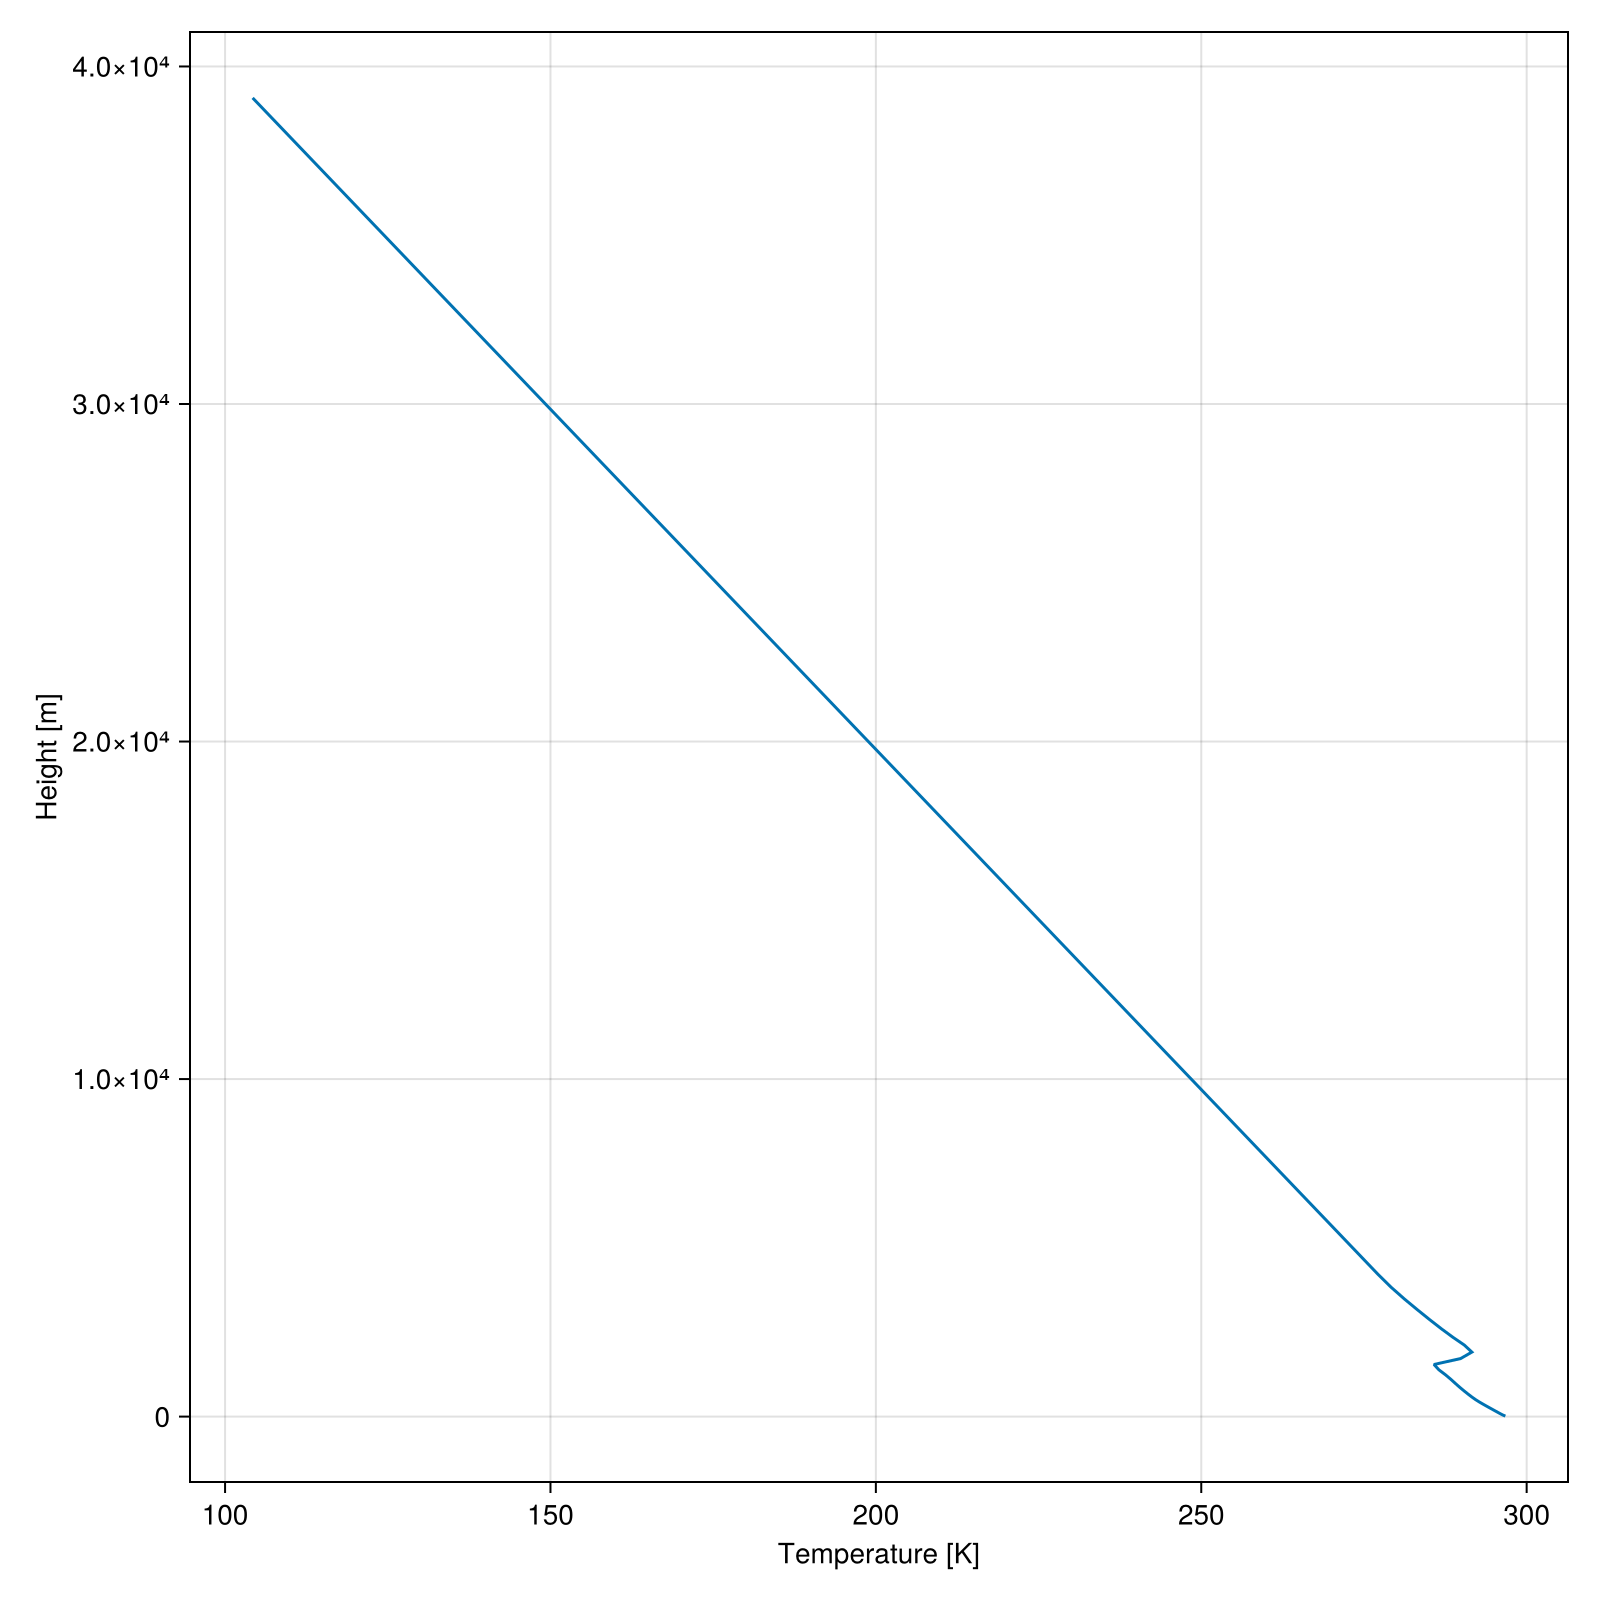

In [181]:
fig = Figure(resolution = (800, 800))
ax = Axis(fig[1, 1], xlabel = "Temperature [K]", ylabel = "Height [m]")
lines!(ax, prof_indices[181:240], zc_model)
fig

In [199]:
CLIMADIAGNOSTICS_LES_NAME_MAP =
    Dict("thetaa" => "theta_mean", "hus" => "qt_mean", "clw" => "ql_mean", "ta" => "temperature_mean")

Dict{String, String} with 4 entries:
  "clw"    => "ql_mean"
  "hus"    => "qt_mean"
  "thetaa" => "theta_mean"
  "ta"     => "temperature_mean"

In [189]:
prof_indices = get_profile(
    filter(x -> occursin("cfsite17", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["clw"]];
    z_scm = zc_model[1:30],
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
prof_indices

30-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.3578615300001086e-8
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not compatible with single column configuration. It will be switched off.
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:211
┌ Info: z heights
│   z_mesh.faces =
│    61-element Vector{ClimaCore.Geometry.ZPoint{Float32}}:
│     ZPoint(0.0)
│     ZPoint(30.0)
│     ZPoint(62.88452)
│     ZPoint(98.928185)
│     ⋮
│     ZPoint(36278.35)
│     ZPoint(38135.195)
└     ZPoint(40000.0)
┌ Info: Resolution stats: 
│   Nq = 1
│   h_elem = 6
│   z_elem = 60
│   ncols = 1
└   ndofs_total = 60
┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not 

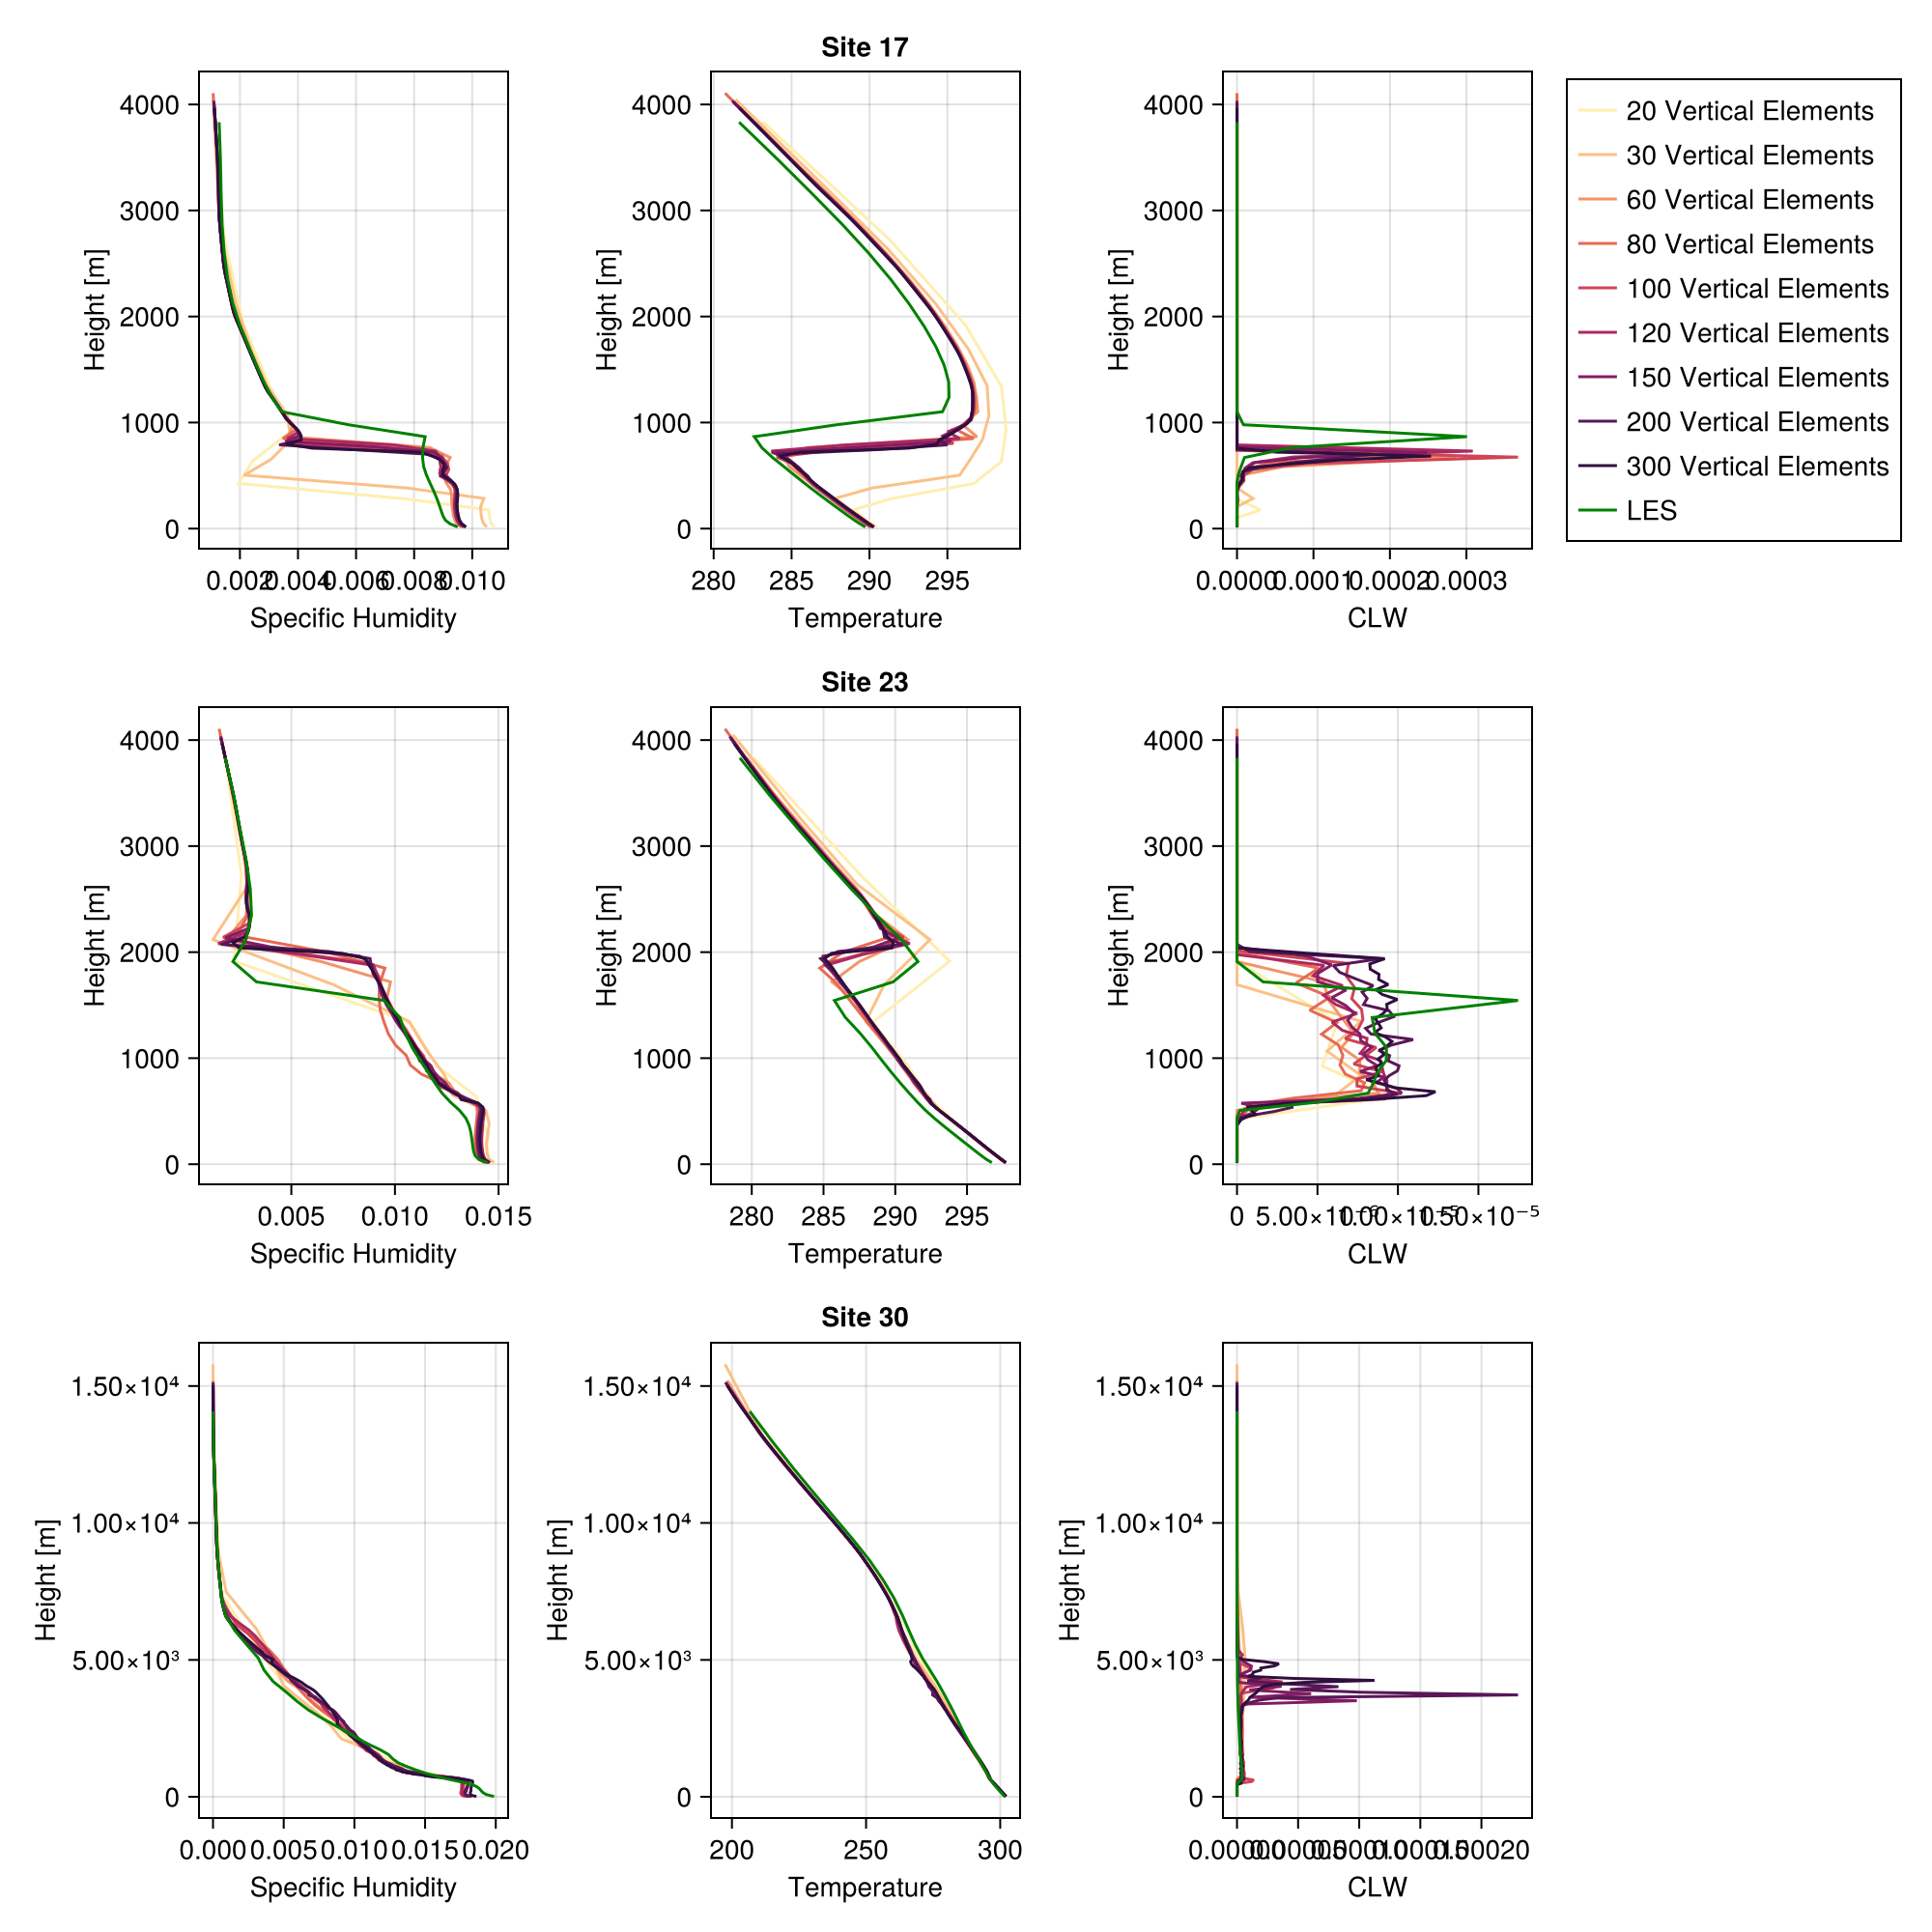

In [207]:
# compare results
# plot hus profiles for site 17
resolutions = [20, 30, 60, 80, 100, 120, 150, 200, 300]
function resolution_experiment_data(var, site; top = 4000.0, to_grid = zc_model, resolutions = [20, 30, 60, 80, 100, 120, 150, 200, 300])
    data = []
    for resolution in resolutions#, 80, 100, 120, 150, 200, 300, 500]         
        simdir = SimDir("output/site_$site/resolution_$resolution/output_active/")
        da = get(simdir; short_name = var, reduction = "inst")
        da = window(da, "time", left = 216000.0, right = 259200.0) # average 2.5 to 3 days
        da = average_time(da)
        da = slice(da, x = 0, y = 0)
        da = window(da, "z", left = 0.0, right = top)
        from_grid = da.dims["z"]
        #interp_data = interp_vertical_prof(to_grid, from_grid, da.data)
        push!(data, da)

    end
    return data#transpose(hcat(data...))
end

fig = Figure(size = (1000, 1000))

height = 4000.
zc_height = get_z_grid(atmos_config, z_max = height);


profiles = resolution_experiment_data("hus", 17)
ax = Axis(fig[1, 1], xlabel = "Specific Humidity", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite17", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["hus"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))

profiles = resolution_experiment_data("ta", 17)
ax = Axis(fig[1, 2], xlabel = "Temperature", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite17", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["ta"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))


profiles = resolution_experiment_data("clw", 17)
ax = Axis(fig[1, 3], xlabel = "CLW", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
# add LES data 
les_data = get_profile(
    filter(x -> occursin("cfsite17", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["clw"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))



# add legend
Legend(fig[1,4], ax)



profiles = resolution_experiment_data("hus", 23)
ax = Axis(fig[2, 1], xlabel = "Specific Humidity", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite23", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["hus"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))


profiles = resolution_experiment_data("ta", 23)
ax = Axis(fig[2, 2], xlabel = "Temperature", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite23", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["ta"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))

profiles = resolution_experiment_data("clw", 23)
ax = Axis(fig[2, 3], xlabel = "CLW", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite23", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["clw"]];
    z_scm = zc_height,
    ti=5.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=6.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))

# add legend
# Legend(fig[2,4], ax)
deep_zmax = 15000.
zc_height = get_z_grid(atmos_config, z_max = deep_zmax);
profiles = resolution_experiment_data("hus", 30; top = deep_zmax)
ax = Axis(fig[3, 1], xlabel = "Specific Humidity", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite30", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["hus"]];
    z_scm = zc_height,
    ti=3.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=4.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))


profiles = resolution_experiment_data("ta", 30; top = deep_zmax)
ax = Axis(fig[3, 2], xlabel = "Temperature", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
les_data = get_profile(
    filter(x -> occursin("cfsite30", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["ta"]];
    z_scm = zc_height,
    ti=3.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=4.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))


profiles = resolution_experiment_data("clw", 30; top = deep_zmax)
ax = Axis(fig[3, 3], xlabel = "CLW", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

les_data = get_profile(
    filter(x -> occursin("cfsite30", x), les_paths)[1],
    [CLIMADIAGNOSTICS_LES_NAME_MAP["clw"]];
    z_scm = zc_height,
    ti=3.5 * 3600 * 24,  # optional ti argument (default already matches)
    tf=4.0 * 3600 * 24,
)
lines!(ax, les_data, zc_height, label = "LES", color = :green, colormap = :matter, colorrange = (1, length(profiles)))

# add legend
# Legend(fig[3,4], ax)

Label(fig[1, 1:3, Top()], "Site 17", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

Label(fig[2, 1:3, Top()], "Site 23", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

Label(fig[3, 1:3, Top()], "Site 30", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

# save figure 
# save("resolution_experiment.png", fig)
fig

In [131]:
palette([:red, :blue, :yellow], 9)

UndefVarError: UndefVarError: `palette` not defined

In [206]:
profiles[1].dims["z"]

14-element Vector{Float32}:
   15.0
   51.29039
  102.787994
  175.83063
  279.36243
  425.97037
  633.2971
  925.93164
 1337.8665
 1915.5513
 2721.4048
 3837.3047
 5366.9253
 7434.795